In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path('./drive/MyDrive/hUlMona')
path.ls()

[PosixPath('drive/MyDrive/hUlMona/data'),
 PosixPath('drive/MyDrive/hUlMona/Ar-LM_unfreeze_1e-4_after3_2_acc475.pth'),
 PosixPath('drive/MyDrive/hUlMona/models'),
 PosixPath('drive/MyDrive/hUlMona/.ipynb_checkpoints')]

## prepare data for MADAMIRA

In [6]:
import string

#preparing punctuations list
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ«»'''
english_punctuations = string.punctuation
punc_to_remove = ''.join(set(arabic_punctuations + english_punctuations))
punc_to_keep = '+'
punc_to_escape = '''[]-^'''
for p in punc_to_keep: punc_to_remove = punc_to_remove.replace(p, '')
for p in punc_to_escape: punc_to_remove = punc_to_remove.replace(p, '\\{}'.format(p))
print(punc_to_remove)

def pre_process(text):
    text = text.replace('\\n', ' ').replace('\n', ' ')
    text = text.replace('؛', '،')
    text = re.sub(r'\([^)]+\)', '', text)  # remove parentheses and everything in between
    text = re.sub(r'[a-zA-Z]', '', text)  # remove non-arabic characters
    text = re.sub(r'\d+(\.\d+)?', ' رقم ', text)  # replace numbers by special token
    for p in punc_to_remove: text = text.replace(p, '')  # remove punctuations
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # remove repeated chars
    text = re.sub(r'\s+', r' ', text)
    return text

(–$?*،.&%»"!\],¦\_\-÷`~@؟<“#؛”='\[/ـ{|\^:>…)×}«;




```
# `Ce texte est au format code`
```

## Fine-Tune pre-trained LM

In [7]:
pretrained_fnames=['Ar-LM_unfreeze_1e-4_after3_2_acc475','itos']

In [9]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(path/'data'/'RES2.csv')
column_names = ["polarity", "text"]
df = df.reindex(columns=column_names)

for i,text in enumerate(df["text"]):
    df["text"][i] = pre_process(text)


print(df.shape)
#df.dropna(inplace=True)
#print(df.shape)
#df.Tweet = df.Tweet.apply(lambda x: pre_process(x))
#df.label.replace({'very_positive':2, 'positive':1, 'neutral':0, 'negative':-1, 'very_negative':-2}, inplace=True)
np.random.seed(42)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape, df_val.shape)
#df.columns
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2642, 2)
(2113, 2) (529, 2)


,polarity,text
1149,1,مطعم ممتاز لولا بطء الخدمة وارتفاع أسعار الوجب...
965,-1,لا أنصح به سيء والأكل بارد والسعر مرتفع النظاف...
2398,0,مطعم تركي طعام جيد و لذيذ لكنه بالنسبة للطفل ح...
440,1,ابراهيم المطعم من تصميمه و نظافته مبين ان جيد ...
508,1,الطعام الأمريكي مكان يصلح لمحبي الأستيك الأمري...


In [10]:
df_train.polarity.value_counts()

 1    1681
 0     218
-1     214
Name: polarity, dtype: int64

In [11]:
df_val.polarity.value_counts()

 1    428
-1     54
 0     47
Name: polarity, dtype: int64

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 1149 to 860
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  2113 non-null   int64 
 1   text      2113 non-null   object
dtypes: int64(1), object(1)
memory usage: 49.5+ KB


In [13]:
df.isnull().sum()

polarity    0
text        0
dtype: int64

In [14]:
ar_tok = Tokenizer(lang='ar')
#data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_val, text_cols=0, label_cols=None, tokenizer=ar_tok, bs=32)
data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_val, text_cols=1, label_cols=None, tokenizer=ar_tok, bs=64, include_bos=False, min_freq=4)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [15]:
data_lm.train_ds.x

LMTextList (2113 items)
مطعم ممتاز xxunk بطء الخدمة xxunk أسعار الوجبات من مطاعم الوجبات السريعة المميزة بالنظافة وجودة الأكل يعاب عليه بطء الخدمة xxunk الأسعار المستمر,لا أنصح به سيء والأكل بارد والسعر مرتفع النظافه غير جيدة xxunk مقارنه xxunk خارج السعوديه ايضاً العماله تعاملهم غير جيد xxunk المطلوب,مطعم تركي طعام جيد و لذيذ لكنه بالنسبة xxunk حار يمكن ان تطلب xxunk أخرى xxunk الدجاج للأطفال على xxunk حال لكن معظم xxunk ذات طعم حار و الشيء اللذيذ جداً هو الخبز الطازج الذي xxunk على xxunk لذيذ جداً لدرجة أنني xxunk معي قطعة خبز من المطعم و لكن هناك تأخر في تلبية الطلب نظرا xxunk لديه مكان للجلوس خارج المطعم xxunk و أيضاً في الداخل,ابراهيم المطعم من xxunk و xxunk xxunk ان جيد جدا و الاسعار طبعا فيه مرتفعه نظرا للمأكولات الجيده xxunk xxunk ان يكون xxunk بالاسعار و جوده في الماكولات,الطعام xxunk مكان يصلح لمحبي xxunk xxunk حيث يتم xxunk xxunk جيدة جدا والسعر مناسب والمكان مناسب للشباب
Path: drive/MyDrive/hUlMona

In [16]:
data_lm.show_batch()

idx,text
0,ذات طعم حار و الشيء اللذيذ جداً هو الخبز الطازج الذي xxunk على xxunk لذيذ جداً لدرجة أنني xxunk معي قطعة خبز من المطعم و لكن هناك تأخر في تلبية الطلب نظرا xxunk لديه مكان للجلوس خارج المطعم xxunk و أيضاً في الداخل ابراهيم المطعم من xxunk و xxunk xxunk ان جيد جدا و الاسعار طبعا فيه مرتفعه نظرا للمأكولات الجيده xxunk xxunk ان يكون xxunk بالاسعار و جوده في
1,xxunk انه مطعم عراقي فعلا لان الجميع xxunk xxunk xxunk تحياتي لكم xxunk واذا xxunk xxunk xxunk xxunk xxunk المطعم موجود ان شاء الله جيدجدا المطعم بمعنى الكلمة xxunk وتنوع الاكل ممتاز والجو العام جيد ومستوى الخدمة والاسعار راقية الا انه يعيبه انه يحتاج xxunk xxunk xxunk حيث xxunk رائحة المشاوي عليه سئ للغاية مطعم سيتي ستار سئ للغاية xxunk النيل طعمها واضح وأسعار xxunk طلبنا وجبات xxunk أشخاص وكانت
2,المكان والخدمة و الإطلالة الرائعة على ميدان xxunk هو مطعم تركي رائع اكلت فيه xxunk ولديه افضل xxunk تذوقتها على الإطلاق سوف أذهب إليه xxunk مرة أخرى جاد أحسن مطعم فول في الإسكندرية جاد هو أحسن مكان لتناول الفول و الفلافل في الإسكندرية فروعه ليست على مستوى واحد في الجودة و لكن أفضلها طبعا جاد وسط البلد xxunk xxunk xxunk جاد في xxunk جيد جدا ممتاز xxunk كل شى جميل
3,ال لم يكن بنفس طعم الذي xxunk سواء xxunk أو xxunk xxunk xxunk أما وجبات البيض التي جربتها xxunk هي هي لايوجد به أي خصوصية أبدا أبدا حتى في قسم العوائل تتوفر قائمة طعام xxunk العربية xxunk xxunk ممتاز المطعم ممتاز عيبه الوحيد ضيق جلسات قسم العائلات الخدمه والاكل والنظافه ممتاز يتميز xxunk برجر xxunk لذيذ وخفيف مطعم xxunk برجر للمأكولات السريعه خدمه متوسطه سعر متوسط المأكولات السريعه غير xxunk
4,من أصناف الحلويات وقد اخترنا نوعية xxunk جدا طيبة عادة ما يكون xxunk بالزبائن في xxunk xxunk من xxunk مطعم العقبة هاوس اسم xxunk في مجال xxunk والمطاعم بمدينة العقبة خاصة xxunk xxunk xxunk رائع على البحر وخدمة جيدة جدا xxunk xxunk xxunk يعني فعلا xxunk ب رقم نجوم xxunk كل xxunk عندهم xxunk xxunk ومتميز بنصح كل الناس بزيارته صراحة أنا xxunk xxunk مع أصدقائي لما xxunk xxunk من


In [17]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150

####################################################################
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2, pretrained_fnames=pretrained_fnames,config=config)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


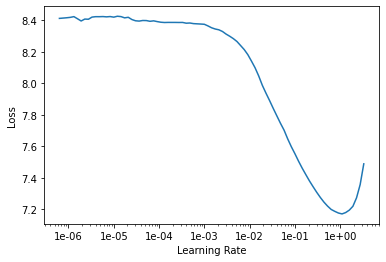

In [18]:
learn_lm.lr_find() 
learn_lm.recorder.plot()

In [19]:
learn_lm.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.693665,5.523140,0.275937,02:31


In [20]:
learn_lm.save('test3_LM')

In [21]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


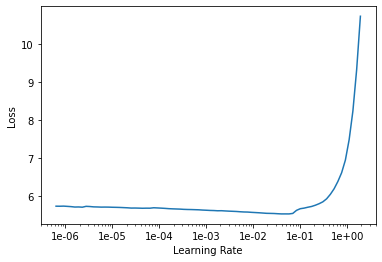

In [22]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [23]:
learn_lm.fit_one_cycle(6, slice(5e-2/(2.6**4),5e-2))

epoch,train_loss,valid_loss,accuracy,time
0,5.541138,5.108276,0.271563,03:47
1,5.239171,4.823138,0.284375,03:45
2,4.859847,4.784012,0.281741,03:32
3,4.404443,4.917262,0.268839,03:28
4,3.866850,5.200093,0.260402,03:30
5,3.390895,5.270626,0.252768,03:32


In [24]:
# learn_lm.save_encoder('att_fine_tuned_encoder')
learn_lm.save_encoder('test3_fine_tuned_encoder')
# 3.935220	4.281686	0.295004

In [25]:
learn_lm.predict('الله يبارك في +ك ', n_words=30)

'الله يبارك في +ك  الله على أكل عجيب كافيه الزحمة جو لطيف للبيتزا مكان يجمع بين الخصوصية دول لطيف مطعم جميل وراقي جدا من جميع النواحي الطعام نظيف جدا مدهش حلوة من اهم العاملين'

## Classifier

In [26]:
ar_tok = Tokenizer(lang='ar')
data_clas = TextClasDataBunch.from_df(path, train_df=df_train, valid_df=df_val, text_cols=1, label_cols=0, tokenizer=ar_tok, bs=32, vocab=data_lm.train_ds.vocab, include_bos=False, min_freq=4, num_workers=0)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [27]:
data_clas.save('data/data_clas_test3.pkl')

In [28]:
data_clas = load_data(path/'data/', 'data_clas_test3.pkl', bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [29]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
تجربة مطعم xxunk لم تكن xxunk ليس xxunk على المطعم و لكن xxunk xxunk هنا xxunk لما xxunk في تجربتي الاولى للمطعم الذي يظهر بأنه مطعم فاخر تم حجز xxunk عبر xxunk لي و قد xxunk على xxunk xxunk الشخص xxunk و xxunk حيث للاسف ان التعامل هناك حسب هذه xxunk عند الوصول للافطار في رمضان قبل xxunk xxunk اي xxunk xxunk انه لم يتم اي حجز و عند السؤال,-1
هذا أفضل بكثير لتناول الشاي بعد xxunk إنه xxunk xxunk بالفعل إنه xxunk xxunk وهو يستحق ذلك لقد جربنا تناول الشاي بعد xxunk يوم السبت xxunk xxunk xxunk xxunk كان xxunk xxunk ورغم ذلك فقد كان ما كان xxunk xxunk عندما طلبنا xxunk xxunk سمك السلمون xxunk xxunk الطعام xxunk آخر xxunk لنا إن كل شيء معد xxunk ولكن ذلك لم يكن xxunk لم تحصل xxunk إلا عندما xxunk بأن,-1
متوسط xxunk محل xxunk بمدينة xxunk xxunk الحقيقة احسن ذكرى لي فيه انني ذهبت اليه مع اغلى xxunk و اخر xxunk لي غير ذلك فهو لم يعجبني xxunk خاصة xxunk الذي xxunk فيه xxunk فرصة ان xxunk طاولة xxunk مكان للعشاء او الغداء و عندما xxunk xxunk تدخل هناك xxunk الواقع xxunk وهو انك حتى و ان كنت xxunk اغلى و افخم xxunk الا ان رائحة الاكل xxunk xxunk ليس,0
بدون xxunk اروع وجبة خلال xxunk قام xxunk xxunk لي الى هذا المطعم و كان يعرف انني احب السمك اول ما اعجبني في المطعم xxunk الذي xxunk xxunk التي xxunk بها xxunk هناك ايضا السرعة و xxunk في الاداء xxunk ان طلبنا طبق السمك xxunk ساعة كان كل شيئ xxunk بالنسبة xxunk سمك معه كل المقبلات ب رقم xxunk فهو ثمن رائع ثم قام صديقي بطلب قطع لحم مشوية و,1
xxunk انا xxunk اش xxunk xxunk رقم يوم جلست عندكم xxunk xxunk xxunk فاتورة xxunk من ما xxunk لكن xxunk لهذا و قلت لها xxunk انا xxunk اش xxunk xxunk رقم يوم جلست عندكم xxunk xxunk xxunk فاتورة xxunk من ما xxunk لكن xxunk لهذا و قلت لها اش هذا xxunk الكلام xxunk xxunk xxunk طاولة بداخل xxunk لكن فيها xxunk xxunk مشكلة xxunk فاتورة تانية xxunk صراحة xxunk كلام,-1


In [30]:
# learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.2, metrics=[accuracy,FBeta(average='weighted')])

# learn_clas.load_encoder('my_fine_tuned_encoder')

config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
del config['tie_weights']
del config['out_bias']

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.2, metrics=[accuracy,FBeta(average='weighted')])
learn_clas.load_encoder('/content/drive/MyDrive/hUlMona/models/test3_fine_tuned_encoder')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (2113 items)
x: TextList
مطعم ممتاز xxunk بطء الخدمة xxunk أسعار الوجبات من مطاعم الوجبات السريعة المميزة بالنظافة وجودة الأكل يعاب عليه بطء الخدمة xxunk الأسعار المستمر,لا أنصح به سيء والأكل بارد والسعر مرتفع النظافه غير جيدة xxunk مقارنه xxunk خارج السعوديه ايضاً العماله تعاملهم غير جيد xxunk المطلوب,مطعم تركي طعام جيد و لذيذ لكنه بالنسبة xxunk حار يمكن ان تطلب xxunk أخرى xxunk الدجاج للأطفال على xxunk حال لكن معظم xxunk ذات طعم حار و الشيء اللذيذ جداً هو الخبز الطازج الذي xxunk على xxunk لذيذ جداً لدرجة أنني xxunk معي قطعة خبز من المطعم و لكن هناك تأخر في تلبية الطلب نظرا xxunk لديه مكان للجلوس خارج المطعم xxunk و أيضاً في الداخل,ابراهيم المطعم من xxunk و xxunk xxunk ان جيد جدا و الاسعار طبعا فيه مرتفعه نظرا للمأكولات الجيده xxunk xxunk ان يكون xxunk بالاسعار و جوده في الماكولات,الطعام xxunk مكان يصلح لمحبي xxunk xxunk حيث يتم xxunk xxunk جيدة جدا والسعر مناسب والمكان مناسب للشباب
y: CategoryList
1,-1,0,1,1
Path: drive/MyDrive/hUl

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


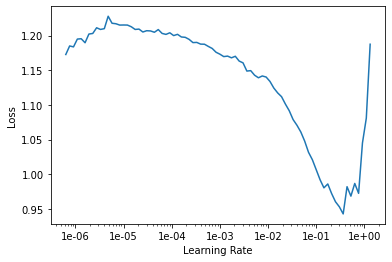

In [31]:
learn_clas.lr_find()
learn_clas.recorder.plot()

In [32]:
learn_clas.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.608967,0.533623,0.820416,0.797335,01:48


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [33]:
learn_clas.save('test3_first_acc685_f643')

In [34]:
learn_clas.load('test3_first_acc685_f643')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2113 items)
x: TextList
مطعم ممتاز xxunk بطء الخدمة xxunk أسعار الوجبات من مطاعم الوجبات السريعة المميزة بالنظافة وجودة الأكل يعاب عليه بطء الخدمة xxunk الأسعار المستمر,لا أنصح به سيء والأكل بارد والسعر مرتفع النظافه غير جيدة xxunk مقارنه xxunk خارج السعوديه ايضاً العماله تعاملهم غير جيد xxunk المطلوب,مطعم تركي طعام جيد و لذيذ لكنه بالنسبة xxunk حار يمكن ان تطلب xxunk أخرى xxunk الدجاج للأطفال على xxunk حال لكن معظم xxunk ذات طعم حار و الشيء اللذيذ جداً هو الخبز الطازج الذي xxunk على xxunk لذيذ جداً لدرجة أنني xxunk معي قطعة خبز من المطعم و لكن هناك تأخر في تلبية الطلب نظرا xxunk لديه مكان للجلوس خارج المطعم xxunk و أيضاً في الداخل,ابراهيم المطعم من xxunk و xxunk xxunk ان جيد جدا و الاسعار طبعا فيه مرتفعه نظرا للمأكولات الجيده xxunk xxunk ان يكون xxunk بالاسعار و جوده في الماكولات,الطعام xxunk مكان يصلح لمحبي xxunk xxunk حيث يتم xxunk xxunk جيدة جدا والسعر مناسب والمكان مناسب للشباب
y: CategoryList
1,-1,0,1,1
Path: drive/MyDrive/hUl

In [35]:
learn_clas.freeze_to(-2)
#learn_clas.lr_find()
#learn_clas.recorder.plot()
#learn_clas.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2))

In [36]:
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.463283,0.497904,0.839319,0.822315,02:09


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [37]:
learn_clas.save('test3_second_acc690_f665_min4')

In [ ]:
learn_clas.load('test3-LEV_preprocessed_second_acc484_f471')

In [ ]:
learn_clas.freeze_to(-3)
#learn_clas.lr_find()
#learn_clas.recorder.plot()
#learn_clas.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

In [ ]:
# to be deleted
learn_clas.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

In [ ]:
learn_clas.save('test3_third_acc692_f665_min4')
# 0.686314	0.656684

In [ ]:
learn_clas.load('test3_third_acc689_f668')

In [ ]:
learn_clas.unfreeze()
#learn_clas.lr_find()
#learn_clas.recorder.plot()

In [ ]:
#learn_clas.unfreeze()
learn_clas.fit_one_cycle(6, slice(1e-4/(2.6**4),1e-4))
# 0.659341	0.857126	0.698801	0.677395

In [ ]:
learn_clas.recorder.plot_losses()

In [ ]:
learn_clas.save('test3_third_acc861_f889')

In [ ]:
# import fastai; 
# fastai.utils.show_install()
print(len(data_clas.vocab.itos) == len(data_lm.vocab.itos))
data_clas.vocab.stoi = data_lm.vocab.stoi
data_clas.vocab.itos = data_lm.vocab.itos
data_clas.vocab = data_lm.vocab

len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

True


True

### Results
|Dataset|epoch|train_loss|valid_loss|accuracy|f_beta  |seed|test split|
|-------|-----|----------|----------|--------|--------|----|----------|
|ASTD-B |6	  |0.438674  |0.448438  |0.864662|0.857988|42  |0.1       |
|ASTD   |6	  |0.659341  |0.857126  |0.698801|0.677395|42  |0.2       |
|AJGT   |5    |0.429798	 |0.452757	|0.805556|0.745665|14  |0.2       |
|LEV    |16   |1.185471  |1.251261  |0.523750|0.511322|14  |0.2       |
|HARD   |7    |0.121737  |0.128373  |0.956695|0.956682|43  |0.2       |